# NLP

## Maël Mandard - Ewen Le Cunff

#### Chargement des librairies

In [58]:
import json
import pandas as pd
import re
from unidecode import unidecode
import nltk
from nltk.corpus import stopwords
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from prince import MCA
from collections import Counter

#### Chargement des données

In [59]:
liste = ['formation0', 'formation1', 'formation2', 'formation3', 'formation4',
         'rupture0', 'rupture1', 'rupture2', 'rupture3', 'rupture4']

date = []
texte = []
theme = []

for obj in liste :
    #f = open(f"C:/Users/Mael/Documents/Fac/M2/NLP/M2_NLP_Mandard_LeCunff/Data/{obj}.json", encoding= 'UTF-8')
    f = open(f"C:/Users/ewen/Documents/M2/NLP/M2_NLP_Mandard_LeCunff/Data/{obj}.json", encoding= 'UTF-8')
    
    data = json.load(f)
    
    them = data['query']['theme']
    
    results = data['results']
    
    for res in results : 
        theme.append(them[0])
        date.append(res['decision_date'])
        texte.append(res['text'])
    

fin_data = pd.DataFrame({'date' : date, 'theme' : theme, 'texte' : texte})

#### Définition de fonctions

In [60]:
def lemmatize(allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    fin_data['texte_lemma'] = fin_data['texte_propre'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if token.pos_ in allowed_postags]))
    return fin_data['texte_lemma']


In [61]:
def plot_top_words(model, feature_names, n_top_words, title, lda_components):
    fig, axes = plt.subplots(2, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for index, topic in enumerate(lda_components):
        top_features_key = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_key]
        weights = topic[top_features_key]
        
        ax = axes[index]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {index +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=30)

    plt.subplots_adjust(top=0.90, bottom=0.1, wspace=0.50, hspace=0.25)
    plt.show()

#### Préparation/Nettoyage de données

Extraction des entités nommées (noms de personnes, d'organisations, de lieux)

In [63]:
nlp = spacy.load('fr_core_news_sm')

def remove_named_entities(text):
    doc = nlp(text)
    new_tokens = (token.text for token in doc if token.ent_type_ == '')
    return ' '.join(new_tokens)

fin_data['text-entite-nommee'] = fin_data['texte'].apply(lambda x: remove_named_entities(x))

Mise en minuscule du texte

In [64]:
def mise_en_minuscule(text):
    return text.replace(text, text.lower())

fin_data['texte_propre'] = fin_data['text-entite-nommee'].apply(lambda x: mise_en_minuscule(x))

Suppression des accents

In [65]:
def remove_accents(text) : 
    return unidecode(text)

fin_data['texte_propre'] = fin_data['texte_propre'].apply(lambda x: remove_accents(x))

Nettoyage du texte (mots qui contiennent un chiffre, remplace les caractères non alphanumériques en espace)

In [66]:
def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text) #supprimer les caractères non alphanumériques
    text = re.sub(r'\b\d+\b', '', text) #supprimer les mots qui contiennent un chiffre
    text = re.sub(r'\b\w\b', '', text) #supprimer les mots qui contiennent une seule lettre
    return text

fin_data['texte_propre'] = fin_data['texte_propre'].apply(lambda x: clean_text(x))

Suppression des stopwords et les mots rares

In [67]:
from nltk.tokenize import word_tokenize

def supprime_stopwords(text, stop_words, rare_threshold=0.2):
    words = re.split(r"[ ]", text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    word_counts = Counter(filtered_words)
    filtered_words2 = [word for word in filtered_words if word_counts[word] >= rare_threshold]
    return ' '.join(filtered_words)

nltk.download('stopwords')
stop_words = set(stopwords.words('french'))
liste_stop = ['soc', 'cds', 'peuple', 'fs', 'audience', 'mm', 'mme', 'mr', 'monsieur', 
              'janvier', 'fevrier', 'mars', 'avril', 'mai', 'juin', 'juillet', 'aout', 'septembre', 'octobre', 'novembre', 'decembre', 
              'dont', 'alors', 'lors', 'meme', 'apos', 'ni', 'non', 'deg',
              'celui', 'ci', 'celle', 'cette', 'ete', 'peut', 'ndeg', 'si', 'donc', 'ainsi', 'tout', 'etre', 'sans',
              'travail', 'salarie', 'cour', 'employeur', 'article', 'code', 'appel', 'avoir',
              'societe', 'contrat', 'arret', 'faire', 'moyen', 'etais', 'etait']
stop_words.update(liste_stop)

fin_data['texte_propre'] = fin_data['texte_propre'].apply(lambda x: supprime_stopwords(x, stop_words))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ewen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Supprime les espaces

In [68]:
def supprime_espace(text):
    words = re.split(r"[ ]", text)
    filtered_words = [word for word in words if word]
    return ' '.join(filtered_words)

fin_data['texte_propre'] = fin_data['texte_propre'].apply(lambda x: supprime_espace(x))

Lemmatisation

In [69]:
def lemmatisation(text, stop_words):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words]
    return ' '.join(lemmatized_tokens)

fin_data['texte_lemma'] = fin_data['texte_propre'].apply(lambda x: lemmatisation(x, stop_words))

In [70]:
fin_data['texte_lemma'][0]

'presider francai exercice liberal responsabilite limitee sieg prise personn qualite liquidateur judiciaire forme pourvoi contre rendre pari pol chambre litige opposer domicili defendeur cassation demanderess invoqu appui pourvoi deux cassation annexe present dossier communiqu procureur general rapport conseiller referendair observation avocat avocat avi avocat general present observation oral public apre debat public etaient present presider conseiller referendair rapporteur conseiller doyen conseiller conseiller referendaire greffier chambre chambre social compose application organisation judiciaire president conseiller preciter apre deliber conformement loi rendre present selon attaque sign location long duree vehicule adhesion systeme informatise developp sou nom rompu relation contractuel saisir juridiction prud homal placee liquidation judiciaire designee qualite liquidateur premier prendre premiere deuxieme troisieme septieme huitieme branche qualite grief requalifier relation c

#### Création du nuage de mots

In [71]:
wordcloud = WordCloud(background_color="white", max_words = 40)
text = " ".join(fin_data['texte_propre'].tolist()) 
wordcloud.generate(text)

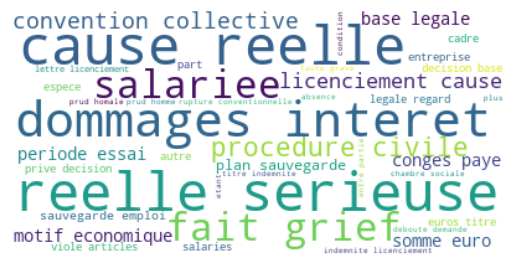

In [72]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Analyse des documents

Création de la matrice document-terme

In [73]:
vec = CountVectorizer()
X_doc_terme = vec.fit_transform(fin_data['texte_lemma'])

Visualisation des termes les plus utilisés

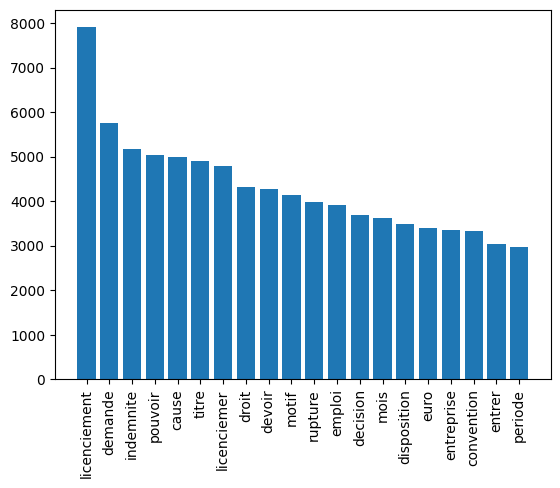

In [74]:
freqs = [(word, X_doc_terme.getcol(idx).sum()) for word, idx in vec.vocabulary_.items()]
freqs = sorted(freqs, key=lambda x: -x[1])

plt.bar([x[0] for x in freqs[:20]], [x[1] for x in freqs[:20]])
plt.xticks(rotation=90)
plt.show()

Création de la matrice TF-IDF

In [75]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(fin_data['texte_lemma'])

Visualisation du TF-IDF

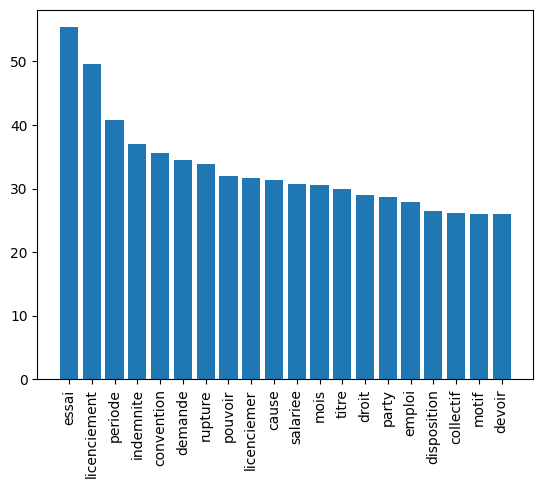

In [76]:
freqs = [(word, X_tfidf.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]
freqs = sorted(freqs, key=lambda x: -x[1])

plt.bar([x[0] for x in freqs[:20]], [x[1] for x in freqs[:20]])
plt.xticks(rotation=90)
plt.show()

#### Réalisation d'une AFC

In [77]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [51]:
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_tfidf)

In [52]:
pca = PCA()
pca.fit(X_scaled.toarray())

PCA()

In [54]:
# Variance expliquée par chaque composante
print(pca.explained_variance_ratio_)

[7.31048437e-03 6.81050726e-03 6.33165605e-03 5.91011795e-03
 5.56652898e-03 5.40571260e-03 5.27867831e-03 5.15412174e-03
 5.07889676e-03 5.01091848e-03 4.92890185e-03 4.75157862e-03
 4.53080253e-03 4.39536855e-03 4.25050751e-03 4.23802015e-03
 4.17056836e-03 4.11553062e-03 3.94564124e-03 3.89680142e-03
 3.86027336e-03 3.81351910e-03 3.72657440e-03 3.70148474e-03
 3.64343891e-03 3.58788005e-03 3.54137436e-03 3.48988032e-03
 3.46690625e-03 3.43790765e-03 3.38474828e-03 3.31841673e-03
 3.29335103e-03 3.26981503e-03 3.25245331e-03 3.23087718e-03
 3.21844893e-03 3.20620813e-03 3.18857245e-03 3.15955033e-03
 3.15083726e-03 3.12926948e-03 3.07348356e-03 3.06781601e-03
 3.03467527e-03 3.01301767e-03 2.98979443e-03 2.94163360e-03
 2.93409604e-03 2.90165335e-03 2.88494950e-03 2.87093062e-03
 2.80542248e-03 2.78914243e-03 2.69684420e-03 2.67787322e-03
 2.66336565e-03 2.65105433e-03 2.64611783e-03 2.61744441e-03
 2.61306359e-03 2.59915425e-03 2.58031436e-03 2.56460414e-03
 2.55419696e-03 2.541811

In [55]:
X_pca = pca.transform(X_scaled.toarray())

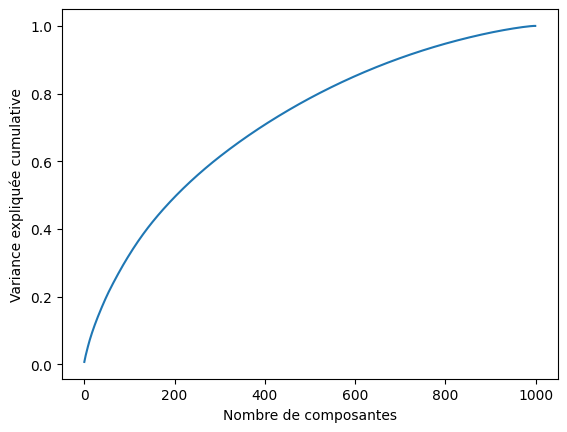

In [57]:
import numpy as np
# Tracer un graphique de la variance expliquée cumulative
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulative')
plt.show()

#### LDA (Latent Dirichlet Allocation)

In [87]:
from sklearn.decomposition import LatentDirichletAllocation

lda_doc_terme = LatentDirichletAllocation(n_components=6, random_state=1234)
lda_matrix_doc_terme = lda_doc_terme.fit_transform(X_doc_terme)

terms_doc_terme = vec.get_feature_names_out()

lda_components_doc_terme=lda_doc_terme.components_

for index, component in enumerate(lda_components_doc_terme):
    zipped = zip(terms_doc_terme, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ", top_terms_list)

Topic 0:  ['periode', 'essai', 'duree', 'mois', 'party', 'demande', 'rupture', 'pouvoir', 'disposition', 'droit']
Topic 1:  ['emploi', 'licenciement', 'economiqu', 'plan', 'motif', 'entreprise', 'reclassemer', 'sauvegard', 'poste', 'groupe']
Topic 2:  ['licenciement', 'demande', 'licenciemer', 'cause', 'titre', 'decision', 'salariee', 'droit', 'pouvoir', 'motif']
Topic 3:  ['rupture', 'heure', 'convention', 'conventionnel', 'demande', 'titre', 'ruptur', 'devoir', 'pouvoir', 'jour']
Topic 4:  ['pouvoir', 'conseil', 'decision', 'subordination', 'lien', 'activite', 'autre', 'faute', 'cause', 'comme']
Topic 5:  ['indemnite', 'titre', 'euro', 'devoir', 'mois', 'montant', 'droit', 'licenciemer', 'salair', 'compte']


In [88]:
lda_tfidf = LatentDirichletAllocation(n_components=5, random_state=1234)
lda_matrix_tfidf = lda_tfidf.fit_transform(X_tfidf)

terms_tfidf = vectorizer.get_feature_names_out()

lda_components_tfidf=lda_tfidf.components_

for index, component in enumerate(lda_components_tfidf):
    zipped = zip(terms_tfidf, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ", top_terms_list)

Topic 0:  ['essai', 'licenciement', 'periode', 'indemnite', 'convention', 'demande', 'rupture', 'pouvoir', 'licenciemer', 'cause']
Topic 1:  ['createur', 'costume', 'decorateur', 'theologie', 'erf', 'costumier', 'radiodiffusion', 'ordination', 'precisees', 'deboutes']
Topic 2:  ['dessinee', 'inspire', 'bande', 'roman', 'dessine', 'applicabler', 'policier', 'actualite', 'scenario', 'imagination']
Topic 3:  ['lamaneur', 'colorist', 'scac', 'lamanage', 'permanentist', 'qualifieer', 'specification', 'coiffur', 'permanentiste', 'classeer']
Topic 4:  ['specification', 'dessinee', 'inspire', 'bande', 'scac', 'artifice', 'kali', 'deboutes', 'revendiquaient', 'coiffeuser']


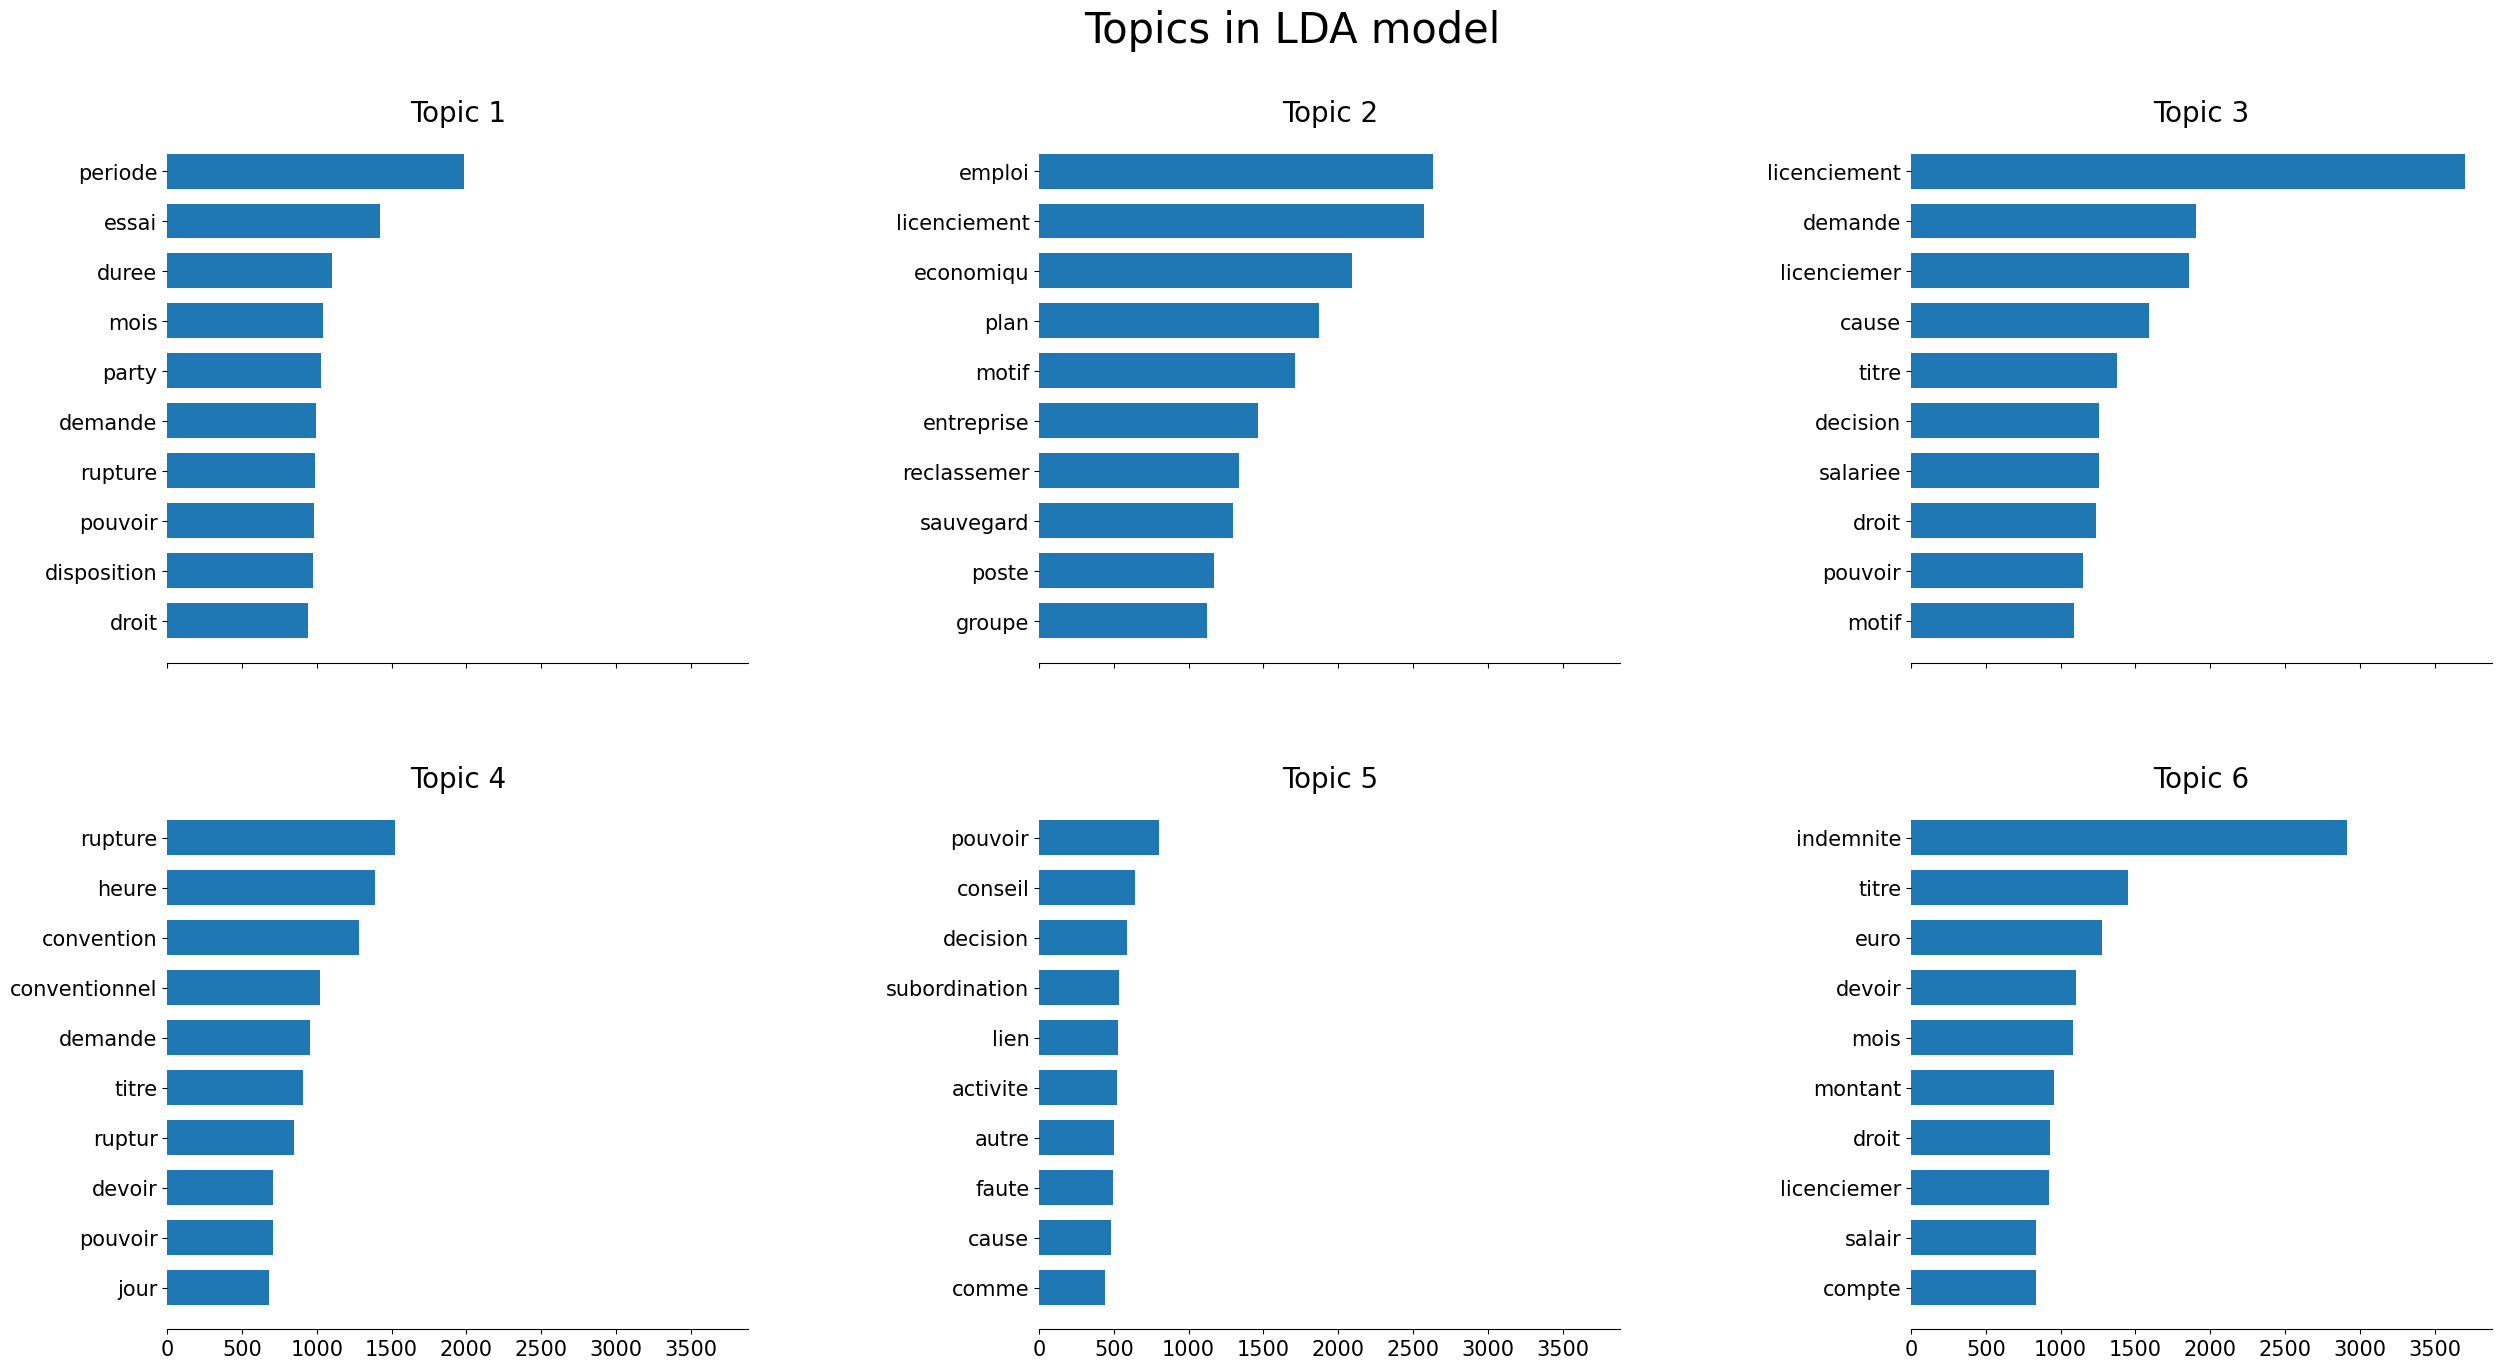

In [89]:
n_top_words = 10
plot_top_words(lda_doc_terme, terms_doc_terme, n_top_words, "Topics in LDA model", lda_components_doc_terme)

Avec matrice document-termes :
1) Tout se qui touche à la période d'essai (demande, rupture)
2) Licenciement économique de la part de l'entreprise
3) Demande de licenciement du salarié pour raison personnelle (cause, motif)
4) Demande de rupture conventionnelle
5) Ne sais pas
6) Tout le domaine qui tourne autour de l'argent (indemnité, salaire, montant, euro)

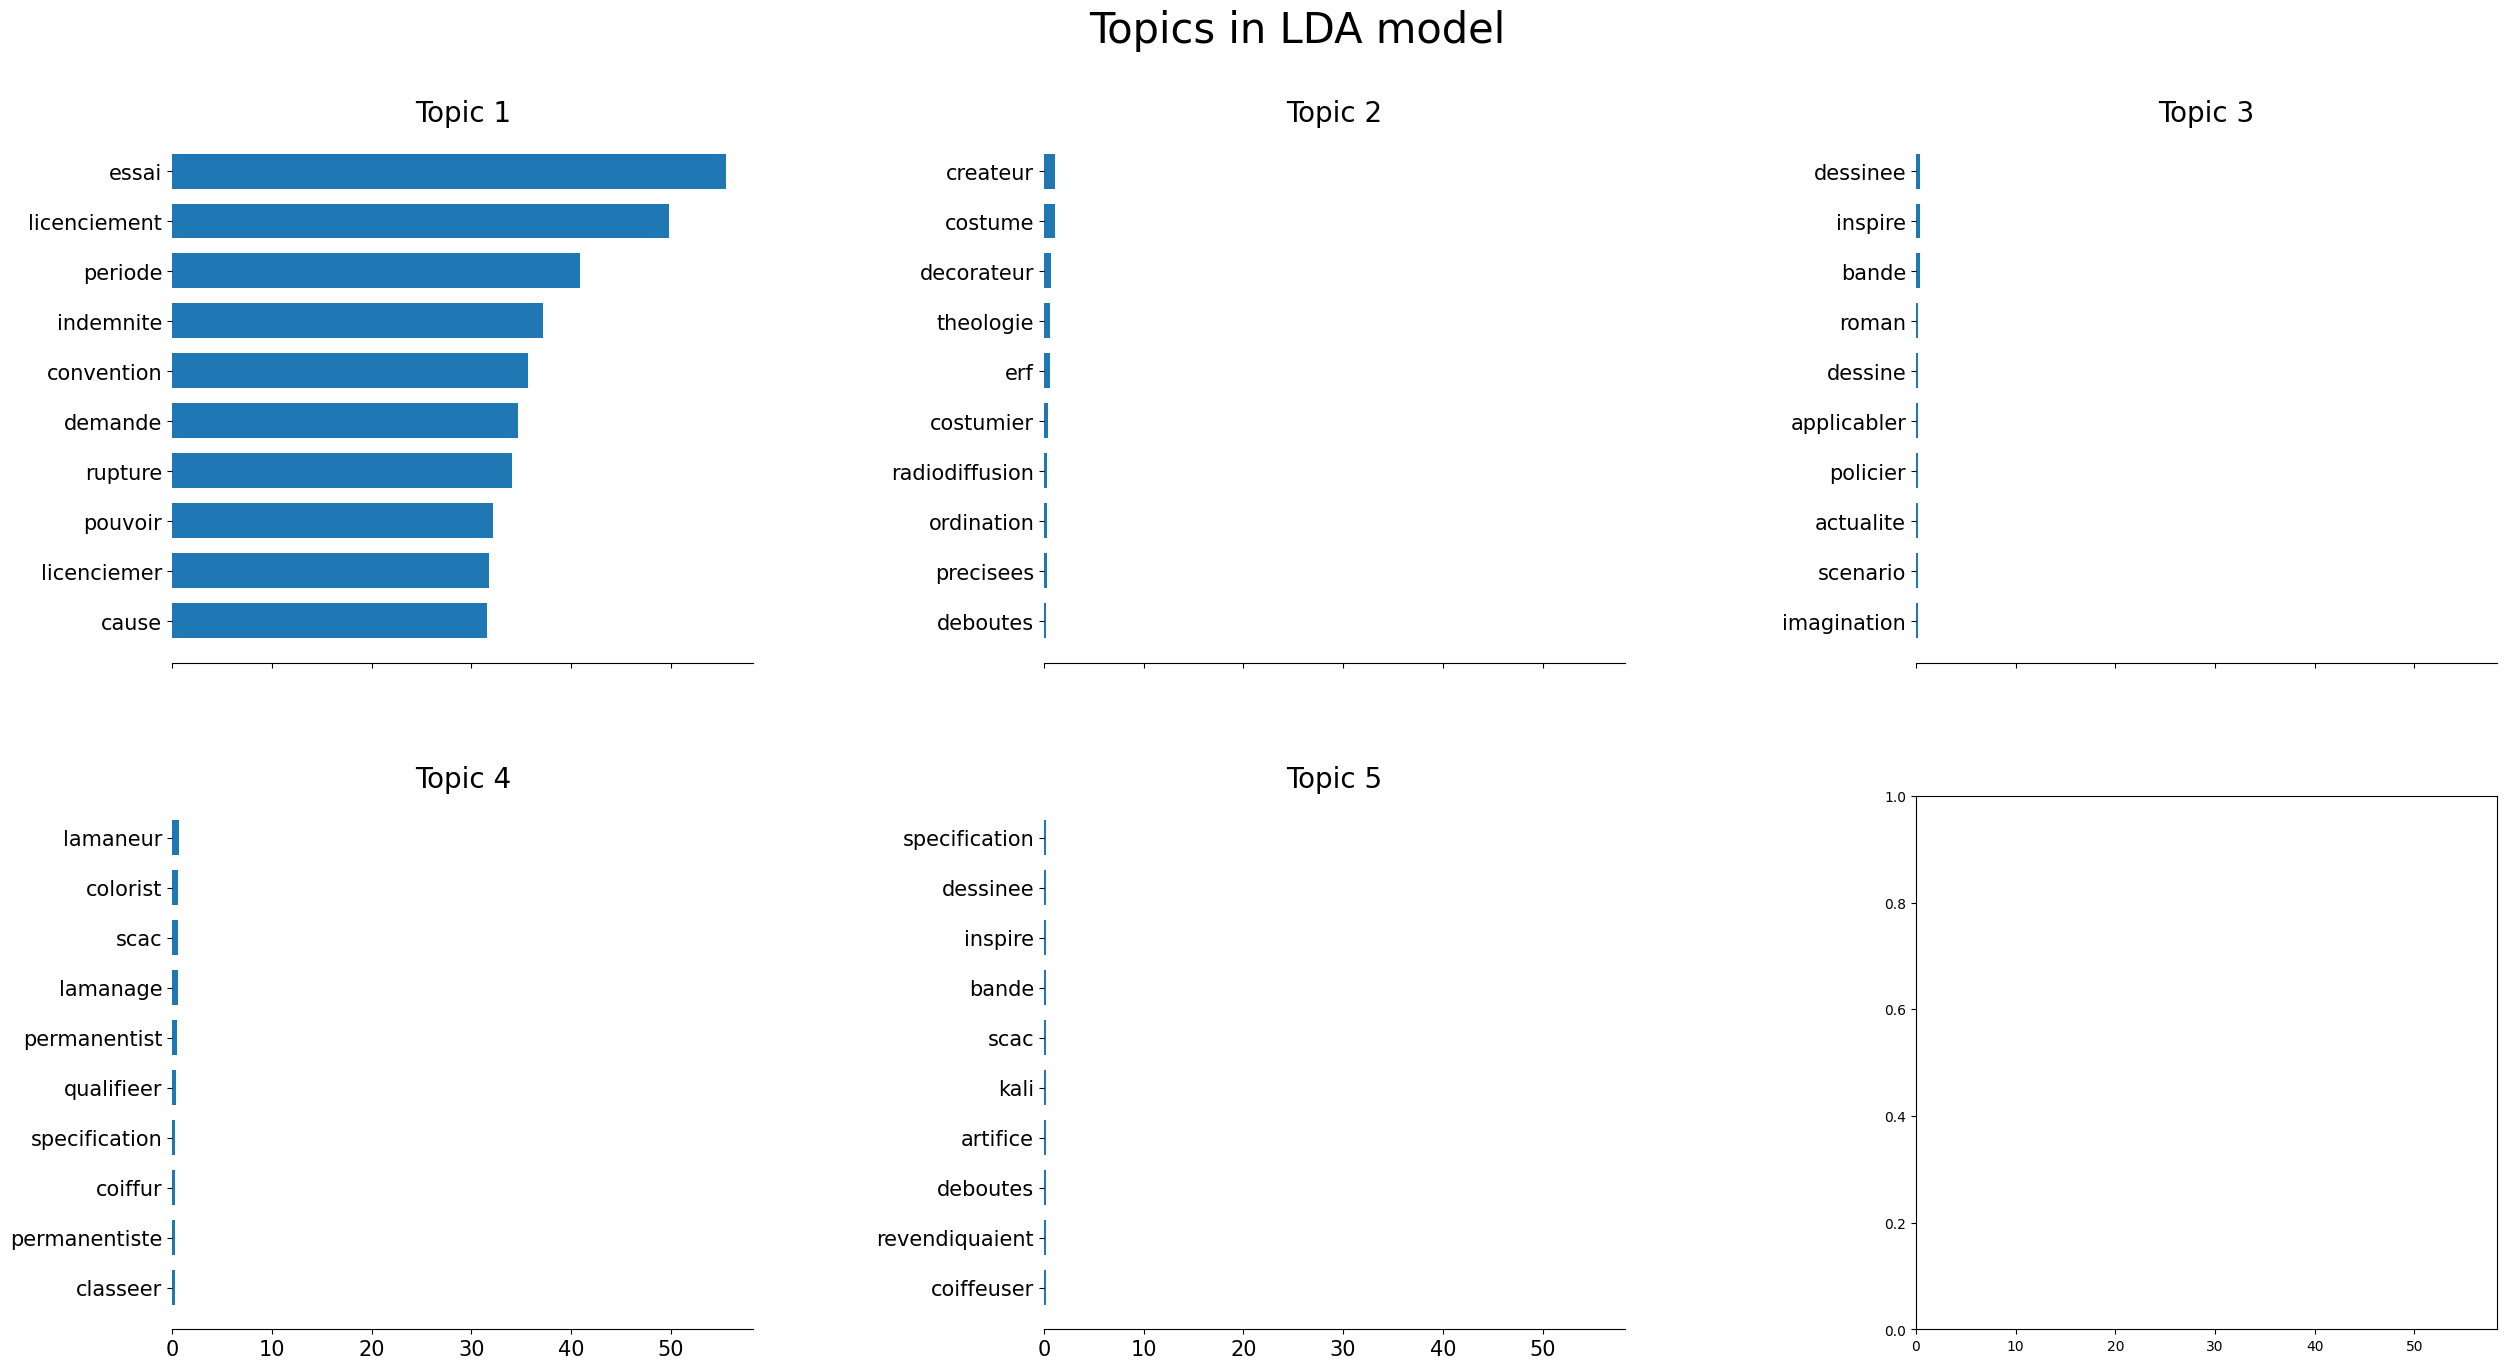

In [90]:
plot_top_words(lda_tfidf, terms_tfidf, n_top_words, "Topics in LDA model", lda_components_tfidf)

Avec matrice tf-idf :
1) Une grande classe, les autres sont pas représentatives

#### NMF

Détection de thématiques

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [95]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2)
X = vectorizer.fit_transform(fin_data["texte_lemma"])

In [98]:
vectorizer = CountVectorizer(max_df=0.5, min_df=2)
X = vectorizer.fit_transform(fin_data['texte_lemma'])

In [99]:
num_topics = 5 # définir le nombre de sujets à extraire
nmf = NMF(n_components=num_topics, random_state=1)
nmf.fit(X)

NMF(n_components=5, random_state=1)

In [100]:
feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(nmf.components_):
    print("Topic #%d:" % topic_idx)
    print(", ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))
    print()

Topic #0:
convention, euro, salair, periode, conge, jour, heure, conventionnel, eur, duree

Topic #1:
emploi, plan, depart, sauvegard, volontaire, reclassemer, reclassement, economiqu, poste, groupe

Topic #2:
accord, economiqu, organisation, comite, procedur, salariee, professionnel, collectif, personnel, projet

Topic #3:
euro, economiqu, comite, entreprendre, economique, salariee, faute, difficulte, groupe, emploi

Topic #4:
chauffeur, service, course, transport, plateform, subordination, prestation, lien, activite, relation



In [34]:
fin_data["topic"] = nmf.transform(X).argmax(axis=1)

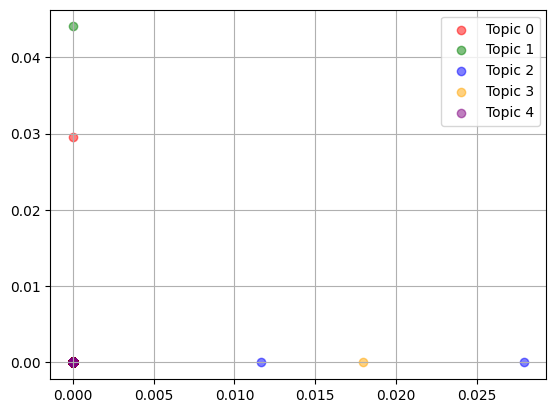

In [35]:
fig, ax = plt.subplots()
colors = ["red", "green", "blue", "orange", "purple"]
for i in range(num_topics):
    ax.scatter(X[fin_data["topic"] == i, 0].toarray(), X[fin_data["topic"] == i, 1].toarray(), c=colors[i], label="Topic %d" % i, alpha=0.5)
ax.legend()
ax.grid(True)
plt.show()